# Notebook for generating EM movies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
from matplotlib import animation, collections
import time
from string import ascii_lowercase

# SimPEG, discretize/
import discretize
from discretize import utils
from simpeg.electromagnetics import time_domain as tdem
from simpeg.electromagnetics import resistivity as dc
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
    Report
)

from simpeg.utils.solver_utils import get_default_solver

In [2]:
Solver = get_default_solver()

<Axes3D: xlabel='x1', ylabel='x2', zlabel='x3'>

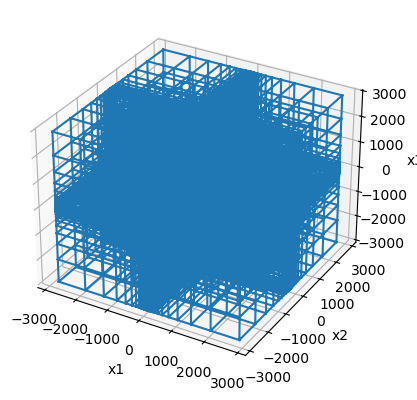

In [3]:
csx = 10
csz = 5

scale = 140

ncx = int(np.ceil(scale/csx))
ncz = int(np.ceil(scale/csx))
nca=1

npadx = 12
npadz = 14

pf = 1.45

mesh = discretize.TensorMesh(
    [
        [(csx, npadx, -pf), (csx, ncx), (csx, npadx, pf)], 
        [(csx, npadx, -pf), (csx, ncx), (csx, npadx, pf)], 
        [(csz, npadz, -pf), (csz, ncz+nca), (csz, npadz, pf)]
    ], 
    origin = "CC0"
)
mesh.origin = mesh.origin + np.r_[0, 0, -mesh.h[2][:npadz+ncz].sum()]
mesh.plot_grid()

In [4]:
mesh

TensorMesh: 62,092 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     38     -2,821.15      2,821.15     10.00    863.81    1.45
   y     38     -2,821.15      2,821.15     10.00    863.81    1.45
   z     43     -2,979.91      2,914.91      5.00    908.08    1.45

In [5]:
rho_back = 100
rho_layer = 20
rho_air = 1e8

slope_layer = -0.2
layer_b = -30
t_layer = 20

def z_layer_top(y): 
    return np.min([np.zeros_like(y), slope_layer * y + layer_b], axis=0)

def z_layer_bottom(y): 
    return np.min([np.zeros_like(y), z_layer_top(y) - t_layer], axis=0)

wire_length = 40

def diffusion_distance(sigma, t):
    return 1260 * np.sqrt(t/sigma)

In [6]:
rx_times = np.logspace(np.log10(1e-6), np.log10(8e-3), 20)
diffusion_distance(1./rho_back, 1e-3)

np.float64(398.4469851812158)

In [7]:
resistivity_model = rho_air * np.ones(mesh.n_cells)
resistivity_model[mesh.cell_centers[:, 2] < 0] = rho_back

halfspace = resistivity_model.copy()

inds_z_layer = (
    (mesh.cell_centers[:, 2] >= z_layer_bottom(mesh.cell_centers[:, 0])) &
    (mesh.cell_centers[:, 2] <= z_layer_top(mesh.cell_centers[:, 0]))
)
resistivity_model[inds_z_layer] = rho_layer

models = {
    "target": resistivity_model,
    "halfspace": halfspace
}

In [8]:
np.unique(resistivity_model)

array([2.e+01, 1.e+02, 1.e+08])

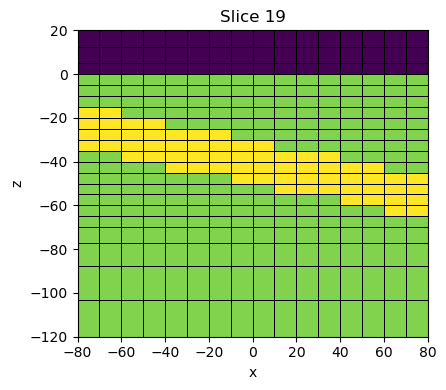

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

xlim = 80*np.r_[-1, 1]
zlim = np.r_[-120, 20]

key = "target"

mesh.plot_slice(
    1./models[key], ax=ax, 
    pcolor_opts={"norm":LogNorm(vmin=1./rho_air*1000, vmax=1./rho_layer)},
    normal="Y", 
    grid=True,
    grid_opts={"color":"k", "lw": 0.5}
)
ax.set_xlim(xlim)
ax.set_ylim(zlim)
ax.set_aspect(1)
    
plt.tight_layout()

## simulation

In [10]:
time_steps = [
    # (1e-4, np.floor(waveform.peak_time/1e-4)), 
    # (1e-5, np.floor((waveform.off_time-waveform.peak_time)/1e-5)), 
    (1e-6, 40), (3e-6, 40), (1e-5, 40), (3e-5, 15), #(1e-4, 5), #(3e-4, 10)
]
rx_times = np.cumsum(np.hstack([np.r_[0], discretize.utils.unpack_widths(time_steps)]))

In [11]:
rx_times.max() * 1e3

np.float64(1.0100000000000005)

In [12]:
waveform=tdem.sources.StepOffWaveform()

rx_y = 50
rx_height = 5


rx_z = tdem.receivers.PointMagneticFluxTimeDerivative(
    np.r_[0, rx_y, rx_height], times=rx_times, orientation="z"
)

loop_src = tdem.sources.CircularLoop(
    radius = wire_length/2,
    receiver_list=[rx_z], waveform=waveform, moment=-1
    # srcType="inductive"
)

wire_src = tdem.sources.LineCurrent(
    location=np.array([
        [0, -wire_length, 0], 
        [0, wire_length, 0],
    ]),
    receiver_list=[rx_z], waveform=waveform,
    srcType="galvanic"
)

survey = tdem.Survey([loop_src]) #, wire_src])

In [13]:
sim = tdem.simulation.Simulation3DElectricField(
    mesh=mesh, survey=survey, time_steps=time_steps, solver=Solver,
    rhoMap=maps.IdentityMap(mesh)
)

In [14]:
fields = {}
dpred = {}

for key, val in models.items():
    t = time.time()
    fields[key] = sim.fields(val)
    dpred[key] = sim.dpred(val, f=fields[key])
    print(f"done {key}... {time.time() - t: 1.2e}s")


/Users/lindseyjh/miniforge3/envs/py311/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


done target...  5.79e+01s
done halfspace...  5.80e+01s


In [15]:
def plot_data(
    ti=None, key="target",src="loop", ax=None, xlim=np.r_[1e-3, 1], ylim=np.r_[1e-10, 1e-2] 
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))

    def plot_loglog(vals, color, label):
        neg_inds = vals < 1e-9
        neg_inds[0] = False
        ax.loglog(rx_times[neg_inds]*1e3, -vals[neg_inds], color, label=label)
        ax.loglog(rx_times[~neg_inds]*1e3, vals[~neg_inds], "--" + color)
    
    
    for i, key in enumerate(["halfspace", "target"]): 
        if src == "loop":
            dpred_vals = dpred[key][:len(rx_times)]
        elif src == "wire": 
            dpred_vals = dpred[key][len(rx_times):]
        plot_loglog(dpred_vals, f"C{i}", key)
            
    if ti is not None: 
        ax.plot(sim.times[ti]*1e3*np.r_[1, 1], ylim, color="k", lw=1)
        # ax.plot(sim.times[ti]*1e3, -dpred["target"][ti], ".k", ms=8)
        
        time_label = (sim.times[ti]-waveform.off_time)*1e3
        if time_label > 0.99: 
            ax.text(0.9, ylim.min()*1.2, f"t={time_label:1.1f} ms", fontsize=14, ha="right")
        else: 
            ax.text(0.9, ylim.min()*1.2, f"t={time_label:1.2f} ms", fontsize=14, ha="right")

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend()
    ax.set_xlabel("time (ms)")
    ax.set_ylabel("db/dt")
    ax.grid(alpha=0.7)
    
    return ax

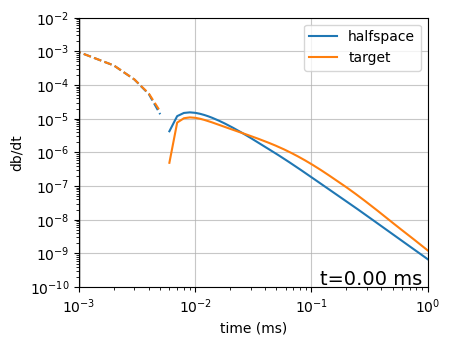

In [16]:
ax = plot_data(1, src="loop")
# ax.set_ylim(1e-15, 1)
# ax.set_xlim(1e-3, 1e1)

In [17]:
def plot_model(
    ti, key = "target", ax=None, xlim=120*np.r_[-1, 1], zlim=np.r_[-120, 20],
    colorbar=False, ylabels=True, vmax=None, cax=None, src="loop"
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    cb = plt.colorbar(mesh.plot_slice(
        1./models[key], ax=ax, 
        pcolor_opts={"norm":LogNorm(vmin=1./rho_air*1000, vmax=1./rho_layer)},
        normal="Y", 
        grid=True,
        grid_opts={"color":[0.5, 0.5, 0.5], "lw": 0.5}
    )[0], ax=ax, cax=cax)
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    ax.set_aspect(1)

    plt.tight_layout()

    cb.set_label("conductivity (S/m)")
    
    if src == "loop":
        ax.plot(-wire_length/2, 0, "wo", ms=6)
        ax.plot(wire_length/2, 0, "wo", ms=6)
    elif src == "wire":
        ax.plot(0, 0, "wo", ms=6)

    ax.plot(rx_y, rx_height, "ws", ms=6)
    
    
    # ax.plot(tx_radius*np.r_[-1, 1], tx_height*np.r_[1, 1], color="C1", lw=2)
    
    ax.text(-wire_length/2, 0+4, f"TX", fontsize=14, ha="center", color="w")
    ax.text(rx_y, rx_height+4, f"RX", fontsize=14, ha="center", color="w")
    
    ax.set_title("")
    
    ax.text(xlim.min() + 2, zlim.min() + 10, f"{rho_back} $\Omega$m", fontsize=14)
    ax.text(xlim.min() + 2, -20, f"{rho_layer} $\Omega$m", fontsize=14)
    ax.text(xlim.min() + 2, 2, f"{rho_air:1.0e} $\Omega$m", color="w", fontsize=14)
    # ax.text(0, target_z, f"{1/sigma_target:1.0f} $\Omega$m", fontsize=14, ha="center", va="center")
    
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    ax.set_aspect(1)


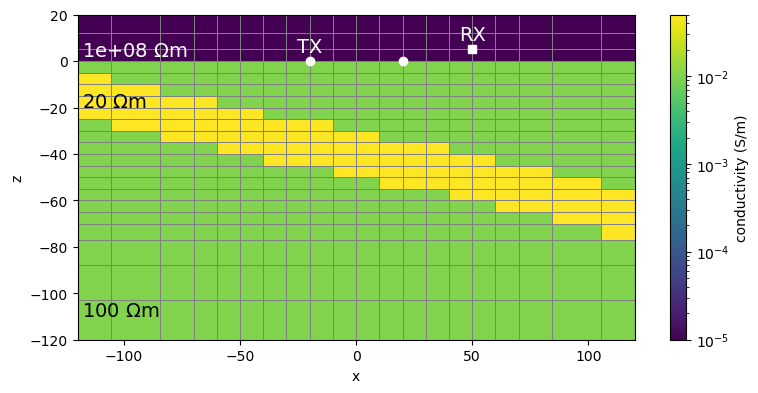

In [18]:
plot_model(0)

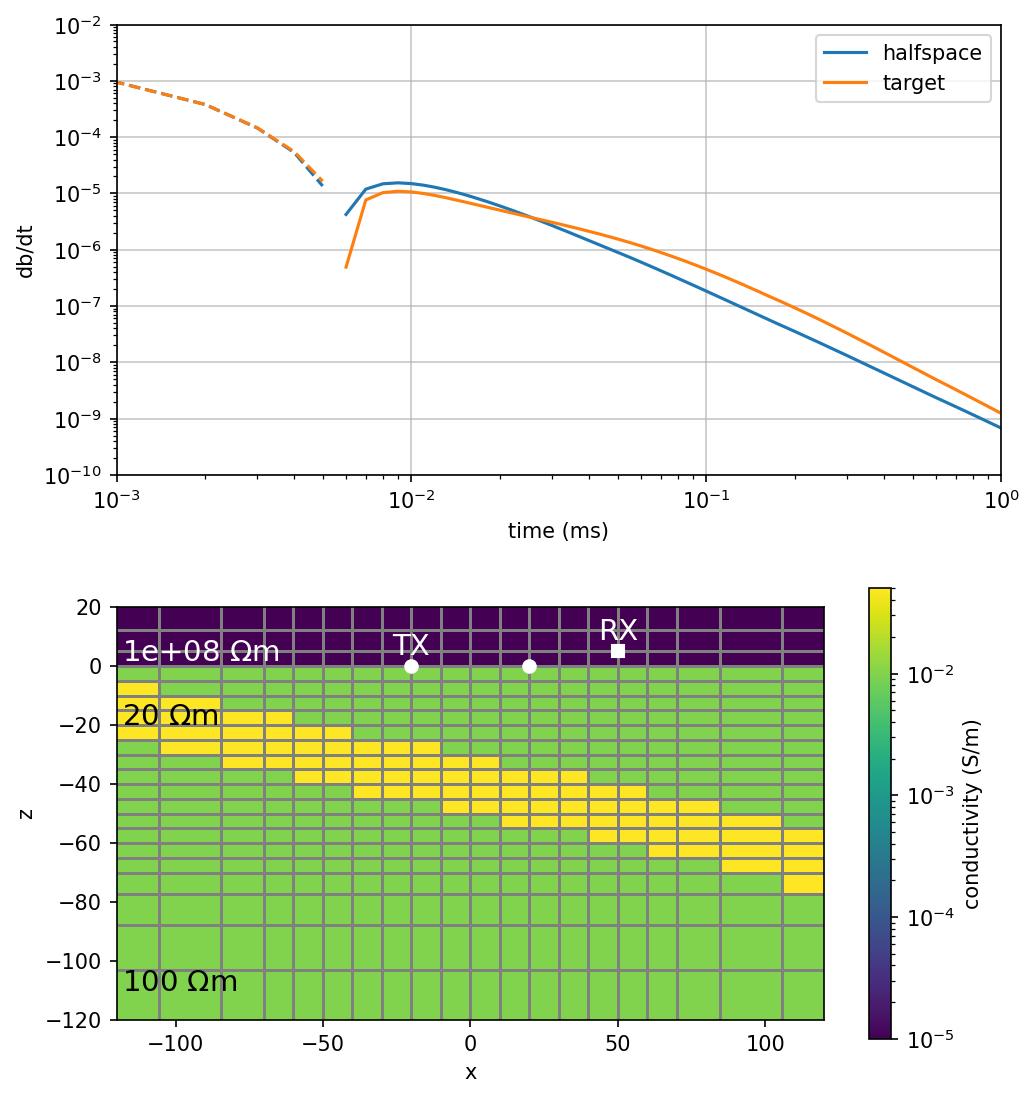

In [19]:
fig, ax = plt.subplots(2, 1, figsize = (7, 7.5), dpi=150) 
plot_data(ax=ax[0])
plot_model(ax=ax[1], ti=0)

In [20]:
def plot_current_density(
    ti, key = "target", src="loop", ax=None, xlim=120*np.r_[-1, 1], zlim=np.r_[-120, 20],
    colorbar=False, ylabels=True, vmax=None, cax=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    if src == "loop": 
        jplt = (mesh.average_edge_y_to_cell * np.squeeze(fields[key][loop_src, "j", ti])[mesh.n_edges_x : np.sum(mesh.n_edges_per_direction[:2])])
        
        # if vmax is not None:
        vmax = np.max(np.abs(jplt))
        pcolor_opts={"norm":Normalize(vmin=-vmax, vmax=vmax), "cmap":"coolwarm"}
        # else: 
        #     pcolor_opts = {"cmap":"coolwarm"}
        out = mesh.plot_slice(
            jplt, ax=ax, 
            pcolor_opts=pcolor_opts,
            normal="y"
        )
    
    
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    ax.set_aspect(1)
    
    if colorbar is True: 
        
        cb = plt.colorbar(out[0], ax=ax, cax=cax)
        ticks = cb.get_ticks()
        cb.formatter.set_scientific(True)
        cb.formatter.set_powerlimits((0,0))
        
        cb.set_ticks([ticks[1], 0, ticks[-2]])
        cb.update_ticks()
        cb.set_label("current density")
    
    
    
    if ylabels is False: 
        ax.set_ylabel("")
        ax.set_yticklabels("")
        
    ax.set_title("")
        
    return cb
        
    
                       



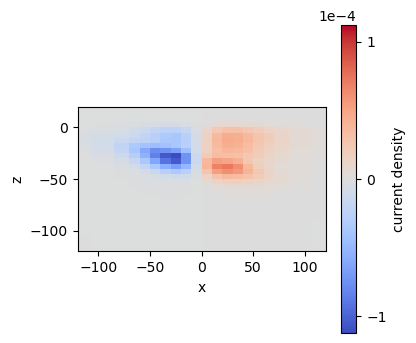

In [21]:
plot_current_density(6, colorbar=True)

In [22]:
def plot_dbdt(
    ti, key = "target", ax=None, xlim=120*np.r_[-1, 1], zlim=np.r_[-120, 20],
    colorbar=False, ylabels=True, vmax=1e-2, vmin=3e-10, cax=None
):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    dbdtplt = -1 * mesh.average_face_to_cell_vector * fields[key][:, "dbdt", ti]
    
    vmin = np.max([vmin, 1e-4*np.max(np.abs(dbdtplt))])
           
    out = mesh.plot_slice(
        dbdtplt, "CCv", view="vec", ax=ax, 
        pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax)},
        range_x=xlim, 
        range_y=zlim,
        stream_threshold=vmin,
        normal="y"
    )
    ax.plot(rx_y, rx_height, "ws", ms=6)
    ax.set_title("")
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    ax.set_aspect(1)
    if ylabels is False: 
        ax.set_ylabel("")
        ax.set_yticklabels("")
    if colorbar is True: 
        cb = plt.colorbar(out[0], ax=ax, cax=cax)
        cb.set_label("db/dt")

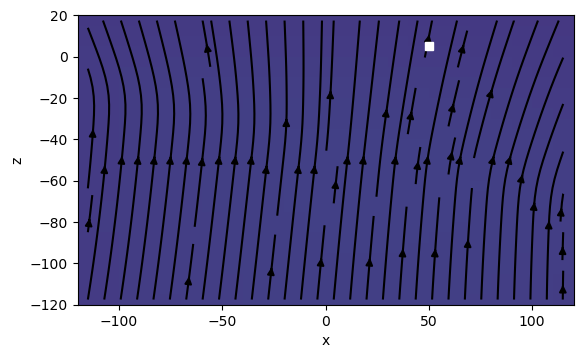

In [23]:
plot_dbdt(120)

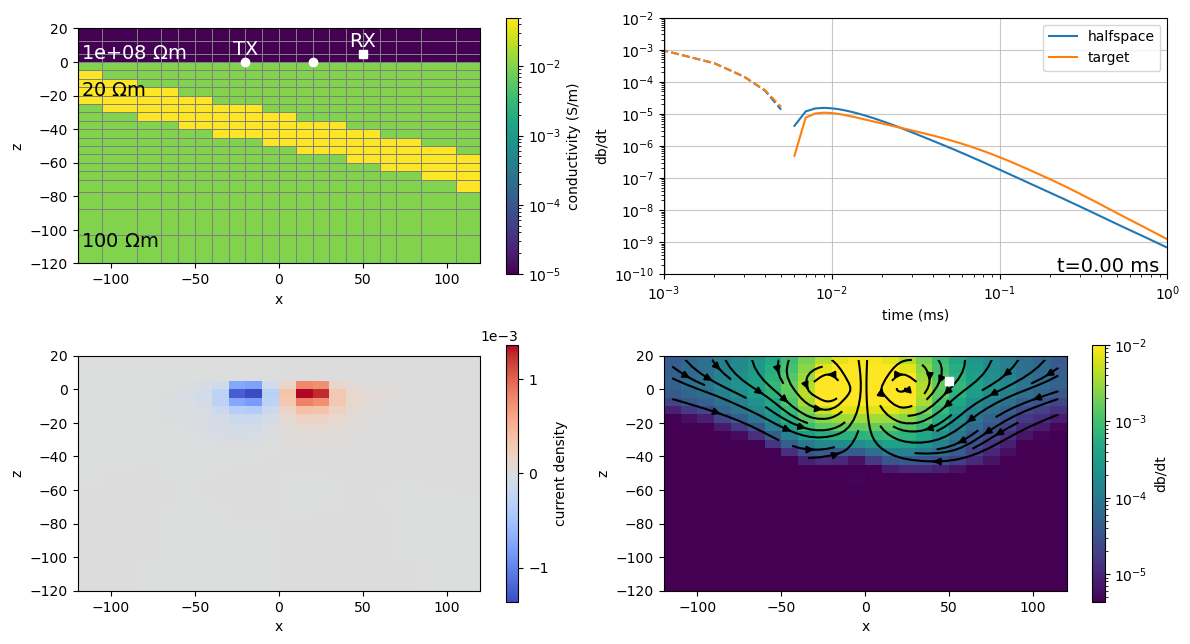

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6.5))
ti = 1
plot_model(ti, ax=ax[0, 0])
plot_data(ti, ax=ax[0, 1])
plot_current_density(ti, ax=ax[1, 0], colorbar=True)
plot_dbdt(ti, ax=ax[1, 1], colorbar=True)

plt.tight_layout()

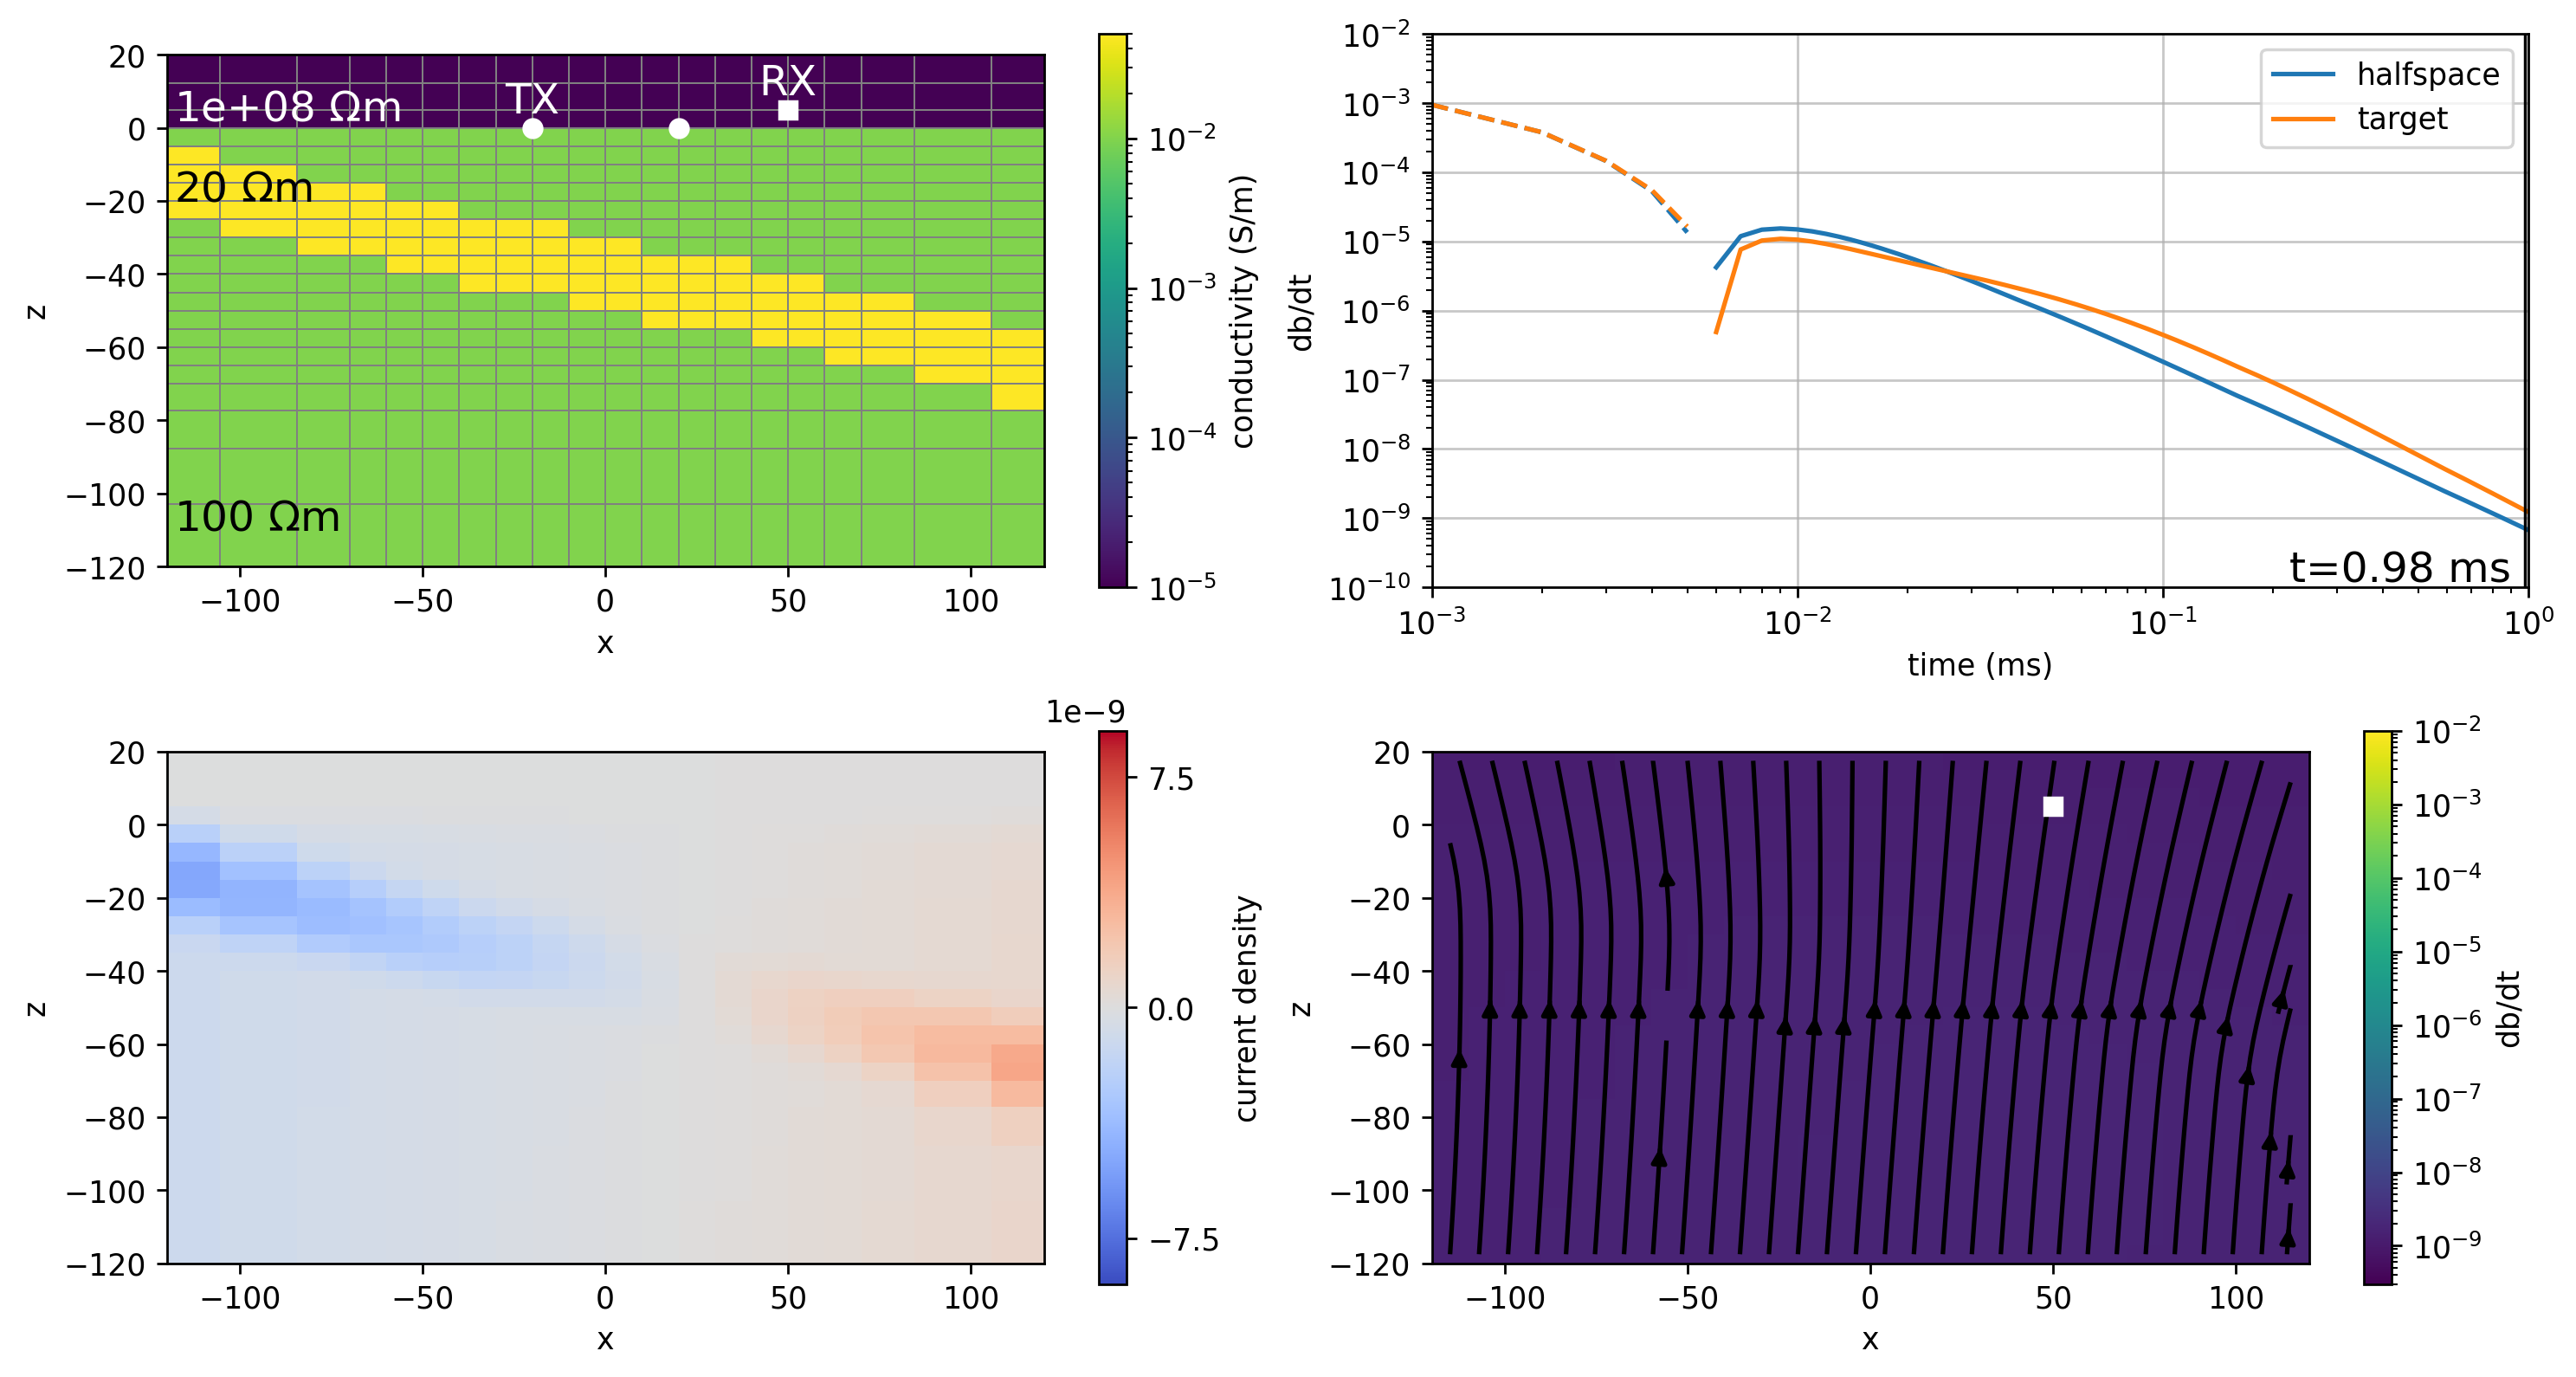

In [25]:
times = np.where(sim.times*1e3 < 1)[0]
ims = []
fig, ax = plt.subplots(2, 2, figsize=(12, 6.5), dpi=250)


def plotme(ti): 
    for a in ax.flatten():
        a.clear()
    if len(fig.get_axes()) > 4:
        axes = fig.get_axes()  
        cax = axes[-3:]
    else: 
        axes = ax.flatten()
        cax = None
    
    
    plot_model(ti, ax=axes[0], colorbar=True, cax=cax[-3] if cax is not None else None)
    plot_data(ti, ax=axes[1])
    plot_current_density(ti, ax=axes[2], colorbar=True, cax=cax[-2] if cax is not None else None)
    plot_dbdt(ti, ax=axes[3], colorbar=True, cax=cax[-1] if cax is not None else None)

    plt.tight_layout()
    
    return ax

out = plotme(0)
def init():
    [o.set_array(None) for o in out if isinstance(o, collections.QuadMesh)]
    return 

def update(t):
    for a in ax.flatten(): 
        a.clear()
    return plotme(t)

ani = animation.FuncAnimation(fig, update, times, init_func=init, blit=False)

ani.save(
    f"./dipping_inductive_video2{key}.mp4", writer="ffmpeg", fps=3, bitrate=0, 
    metadata={"title":f"TDEM {key} currents", "artist":"Lindsey Heagy"}
)


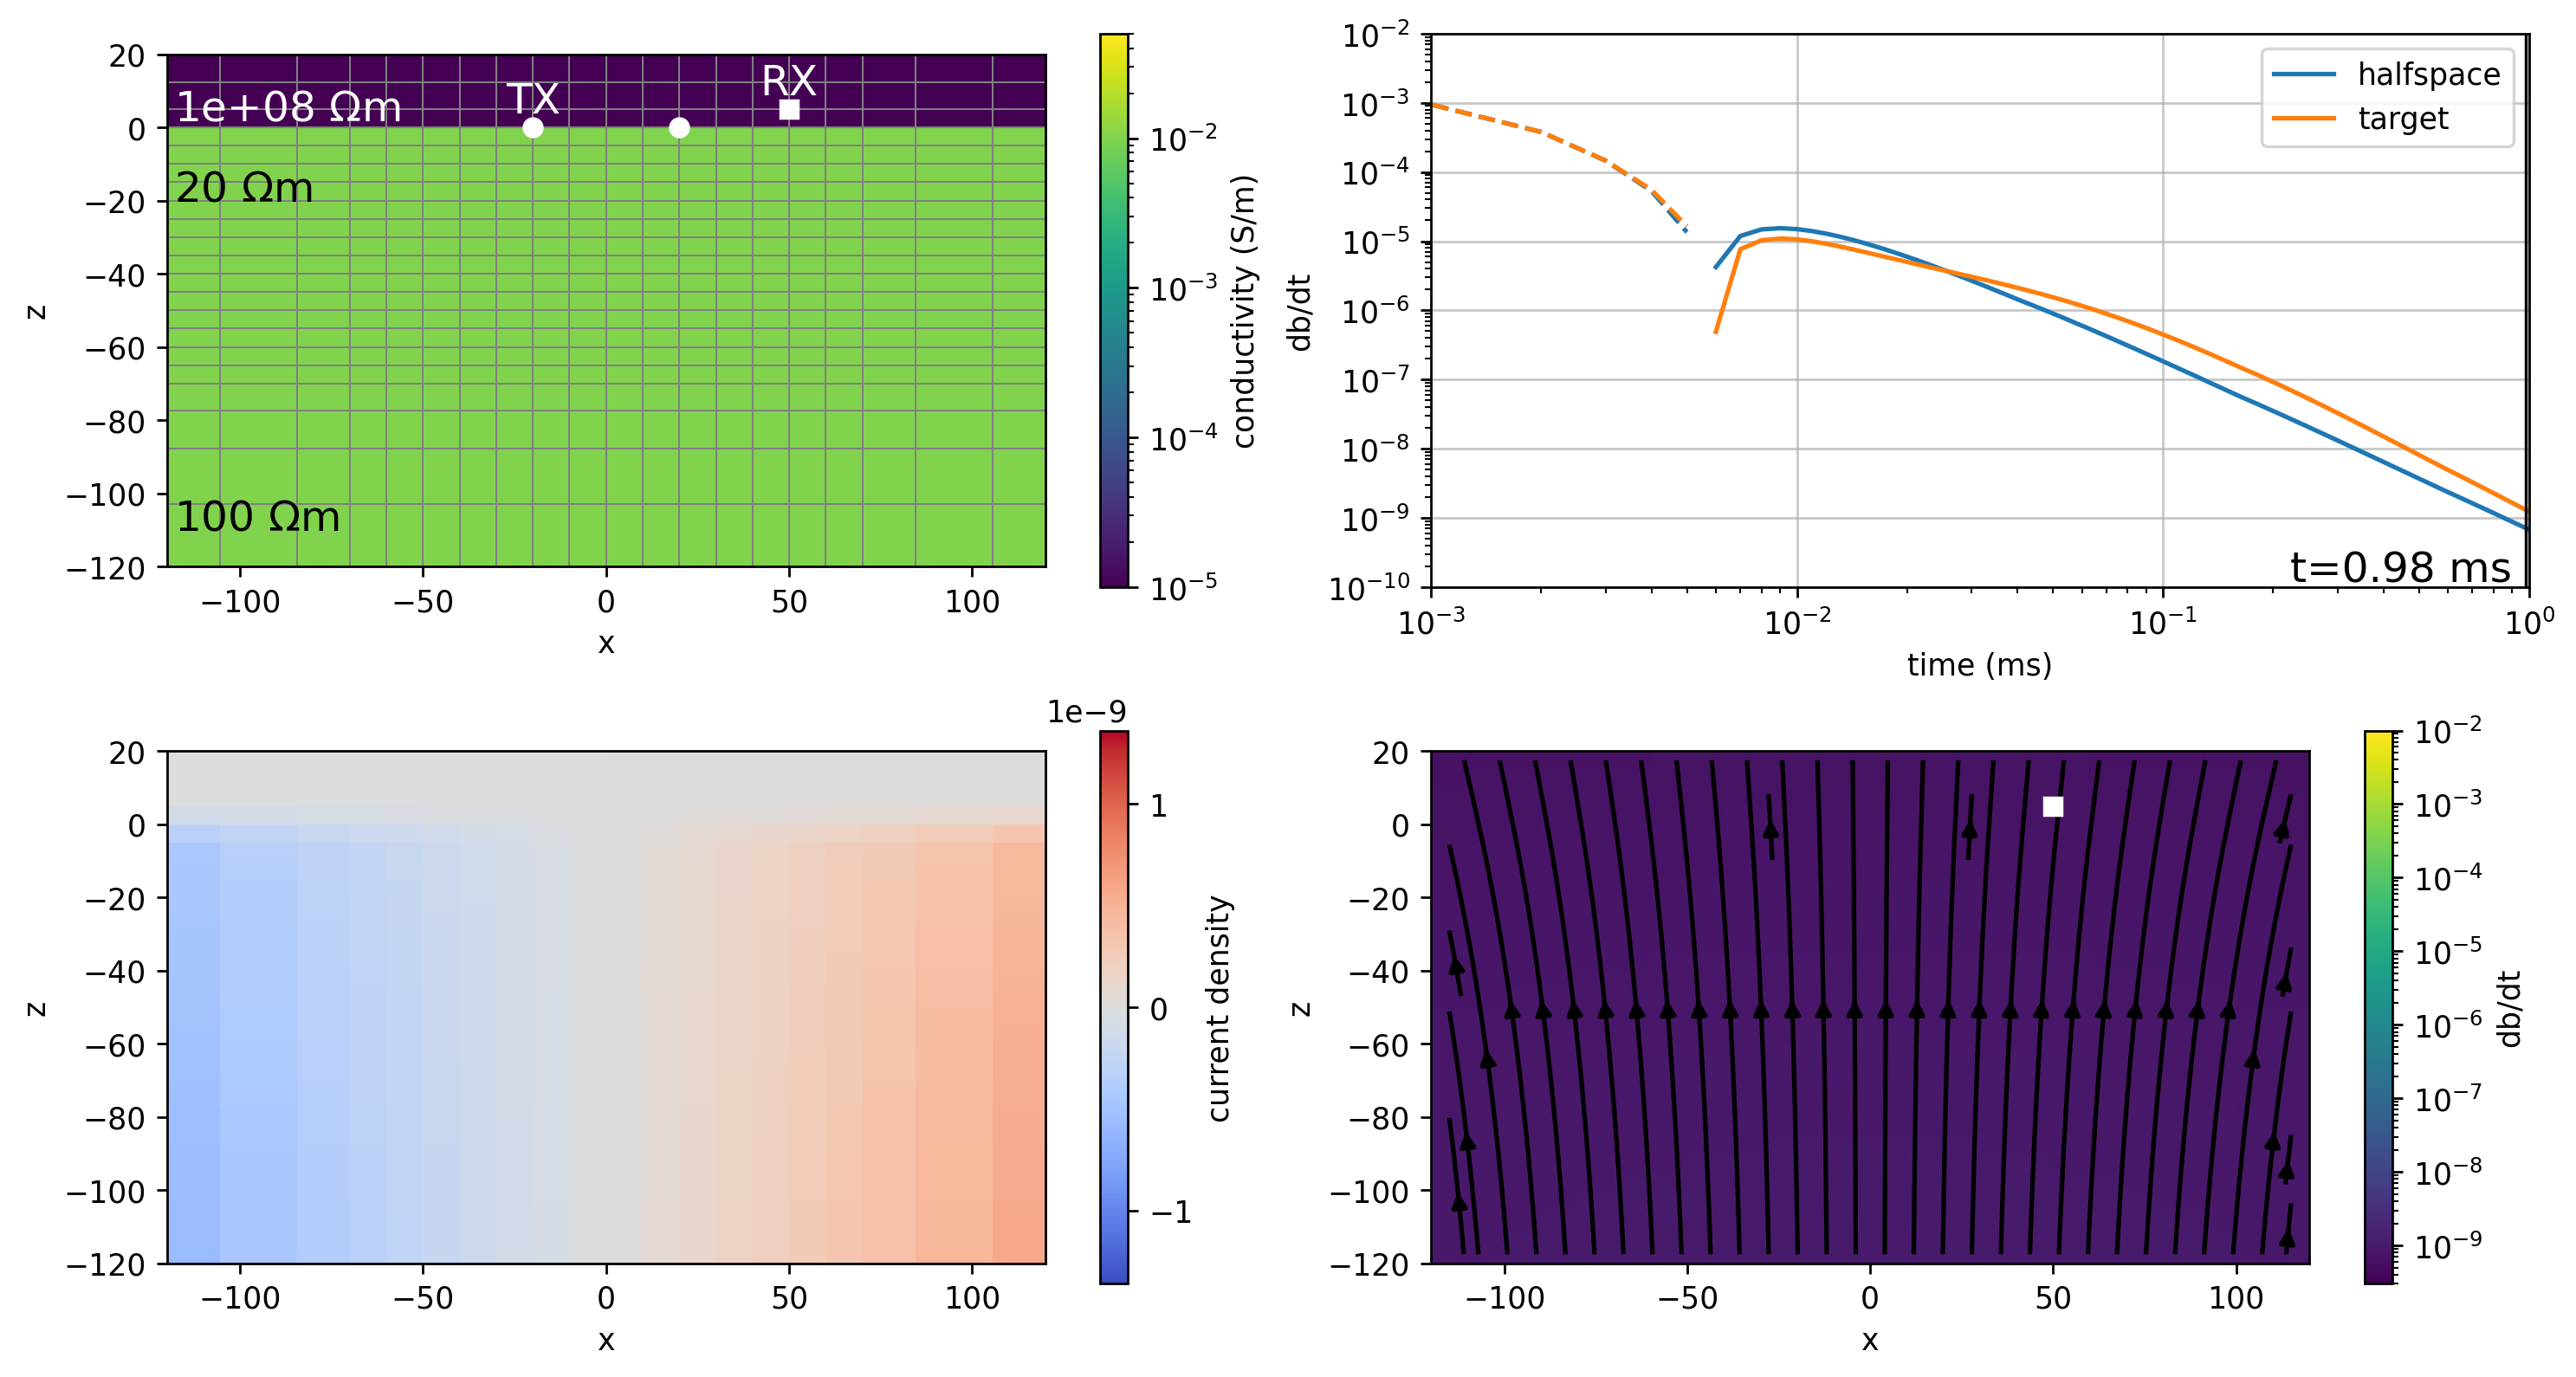

In [26]:
times = np.where(sim.times*1e3 < 1)[0]
ims = []
fig, ax = plt.subplots(2, 2, figsize=(12, 6.5), dpi=250)


def plotme(ti): 
    for a in ax.flatten():
        a.clear()
    if len(fig.get_axes()) > 4:
        axes = fig.get_axes()  
        cax = axes[-3:]
    else: 
        axes = ax.flatten()
        cax = None
    
    
    plot_model(ti, key="halfspace", ax=axes[0], colorbar=True, cax=cax[-3] if cax is not None else None)
    plot_data(ti, ax=axes[1])
    plot_current_density(ti, key="halfspace", ax=axes[2], colorbar=True, cax=cax[-2] if cax is not None else None)
    plot_dbdt(ti, key="halfspace", ax=axes[3], colorbar=True, cax=cax[-1] if cax is not None else None)

    plt.tight_layout()
    
    return ax

out = plotme(0)
def init():
    [o.set_array(None) for o in out if isinstance(o, collections.QuadMesh)]
    return 

def update(t):
    for a in ax.flatten(): 
        a.clear()
    return plotme(t)

ani = animation.FuncAnimation(fig, update, times, init_func=init, blit=False)

ani.save(
    f"./halfspace_inductive_video2{key}.mp4", writer="ffmpeg", fps=3, bitrate=0, 
    metadata={"title":f"TDEM {key} currents", "artist":"Lindsey Heagy"}
)


In [27]:
Report()

--------------------------------------------------------------------------------
  Date: Sat Jan 25 10:25:39 2025 PST

                OS : Darwin (macOS 13.6.6)
            CPU(s) : 12
           Machine : arm64
      Architecture : 64bit
               RAM : 64.0 GiB
       Environment : Jupyter
       File system : apfs

  Python 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:26:25)
  [Clang 17.0.6 ]

            simpeg : 0.22.2.dev41+ge21040475
        discretize : 0.11.0
       pymatsolver : 0.3.1
             numpy : 2.0.0
             scipy : 1.14.1
        matplotlib : 3.9.2
            geoana : 0.7.2
            libdlf : 0.3.0
            cython : 3.0.11
             numba : 0.60.0
           sklearn : 1.5.2
            pandas : 2.2.3
             sympy : 1.13.3
           IPython : 8.29.0
        ipywidgets : 8.1.5
            plotly : 5.24.1
--------------------------------------------------------------------------------